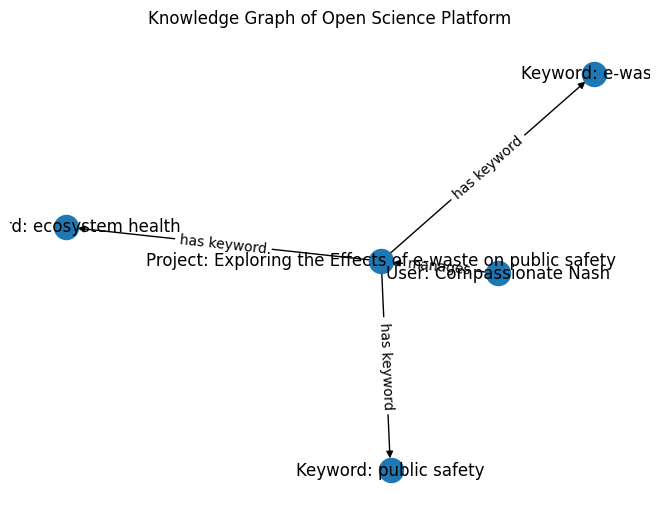

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample JSON-LD data
jsonld_data = {
    "@context": {
        "User": "https://schema.org/Person",
        "Project": "https://schema.org/CreativeWork",
        "Keyword": "https://schema.org/keywords"
    },
    "@graph": [
        {
            "@type": "User",
            "name": "Compassionate Nash",
            "email": "compassionate_nash@email.com",
            "affiliation": "Ecole Nationale Supérieure des Arts et Industries Textile",
            "role": "author"
        },
        {
            "@type": "Project",
            "title": "Exploring the Effects of e-waste on public safety",
            "abstract": "This study aims to investigate the effects of e-waste on public safety and propose strategies for improvement.",
            "startDate": "2019-11-06",
            "endDate": "2022-01-28",
            "funder": "European Union Horizon 2020",
            "keywords": ["e-waste", "public safety", "ecosystem health"]
        }
    ]
}

# Create a new directed graph
G = nx.DiGraph()

# Add User node
user_data = jsonld_data['@graph'][0]
user_node = f"User: {user_data['name']}"
G.add_node(user_node, type='User')

# Add Project node
project_data = jsonld_data['@graph'][1]
project_node = f"Project: {project_data['title']}"
G.add_node(project_node, type='Project')

# Add Keyword nodes
for keyword in project_data['keywords']:
    keyword_node = f"Keyword: {keyword}"
    G.add_node(keyword_node, type='Keyword')
    G.add_edge(project_node, keyword_node, label='has keyword')

# Add edge from User to Project
G.add_edge(user_node, project_node, label='manages')

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'label')

nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Knowledge Graph of Open Science Platform")
plt.show()
